In [15]:
import lammps
import random
from tqdm import trange
import pymc3 as pm
import arviz as az
import numpy as np
import pymatgen as pmg
import theano.tensor as tt
import glob
from copy import deepcopy
import matplotlib.pyplot as plt

from poscar_to_lammps import poscar_to_lammps
from pymatgen.io.vasp import Poscar

import sys
from contextlib import contextmanager

In [16]:
def setup_parameters():
    """
    Contains and returns the setup information.
    
    Args:
        None.

    Returns:
        core_shell (dict): A dictionary of booleans defining which elements are core-shell species.
                           Key = atom label (str) and value = True or False (bool)
        charges (dict): A dictionary of charges for each atom type. Key = Atom label(str),
                        value = either the charge (float) for non-core-shell species, or a sub-dictionary
                        containing { 'core': core_charge (float), 'shell': shell_charge (float) }.
        structures (list): A list of lammps input file names generated from the POSCARs.
        elements (list): A list of the elements in the structure, with core and shell entered separately.
        pairs (list): A list of interacting atom pairs used for defining the pair_coeff.
        cs_springs (dict): A dictionary of the bond_coeff values. Key = atom label and
                           values = K (energy/distance^2) and r0 (equilibrium bond distance) (list).
        bpp_def (dict): A dictionary of the default/starting values for the buckingham potentials.
                        Key = atom1_atom2_parameter (str) and value = parameter (float).
        bpp (dict): Same as bpp_def however the values will change during the fitting process.
                    Key = atom1_atom2_parameter (str) and value = parameter (float).
    """
    core_shell = { 'Li': False , 'Ni': False, 'O': True}

    charges = {'Li': +1.0,
               'Ni': +3.0,
               'O': {'core':  +0.960,
                     'shell': -2.960}}
    
     # 3. Load a POSCAR or list of POSCARs using pymatgen and appends to a list of structures
    structures = structs_from_poscars(core_shell, charges)

    elements = ['Li', 'Ni', 'Oc', 'O'] #shells must be stated as element label. Relabel cores if needed.
    li, ni, oc, o = elements

    pairs = [(li,o), (ni,o), (o,o)]

    #Must be in same order given in charges dictionary
    cs_springs = {o : [65.0, 0.0]} #Set to None if not using any core-shells
    

    bpp_def = {'Li_O_A'   : 632.1018,
               'Li_O_rho' : 0.2906,
               'Li_O_C'   : 0.0,
               'Ni_O_A'   : 1582.5000,
               'Ni_O_rho' : 0.2882,
               'Ni_O_C'   : 0.000,
               'O_O_A'    : 22764.3000,
               'O_O_rho'  : 0.1490,
               'O_O_C'    : 21.7}

    bpp = deepcopy(bpp_def)
    
    return core_shell, charges, structures, elements, pairs, cs_springs, bpp_def, bpp

In [17]:
@contextmanager
def custom_redirection(fileobj):
    """
    Redirects print to file.
    
    Args:
        fileobj (file): File name to redirect print to

    Returns:
        None.
    """
    old = sys.stdout
    sys.stdout = fileobj
    try:
        yield fileobj
    finally:
        sys.stdout = old

def structs_from_poscars(core_shell, charges):
    """
    Reads in POSCARs, creates equivalent lammps inputs.
    
    Args:
        core_shell (dict): A dictionary of booleans stating if any atoms should be made core-shell.
        charges (dict): A dictionary of charges for each atom type. Key = Atom label(str),
                        value = charge(float)/sub_dict(dict). If atom is core-shell a sub dictionary
                        will be the value, where sub_key = 'core' or 'shell' and sub_value = charge(float).

    Returns:
        structures (list): A list of lammps imput file names generated from the POSCARs.
    """
    structures = []
    for i, structure in enumerate(glob.glob('poscars/POSCAR*')):
        file = 'lammps/coords{}.lmp'.format(i+1)
        with open(file, 'w') as struct:
            with custom_redirection(struct):
                poscar = Poscar.from_file(structure)
                poscar_to_lammps(poscar, core_shell, charges )
        structures.append(file)
    return structures

In [18]:
core_shell, charges, structures, elements, pairs, cs_springs, bpp_def, bpp = setup_parameters()

In [19]:
def init(structure, cs_springs=None):
    """
    Initialises the system from the structure (read in from lammps input) and non-changing parameters.
    
    Args:
        structure (str): Name of lammps input file.
        cs_springs (dict): A dictionary of the bond_coeff values. Key = atom label and
                           values = K (energy/distance^2) and r0 (equilibrium bond distance) (list).
                           Default = None.

    Returns:
        lmp (Lammps): Lammps system with structure and specified commands implemented.
    """
    lmp = lammps.Lammps(units='metal', style = 'full', args=['-log', 'none', '-screen', 'none'])
    lmp.command('read_data {}'.format(structure))

    lmp.command('group cores type 1 2 3') #MAKE BOTH MORE GENERIC FROM READING CHARGE LIST?
    lmp.command('group shells type 4')

    if cs_springs:
        lmp.command('pair_style buck/coul/long/cs 10.0')
        lmp.command('pair_coeff * * 0 1 0')

        lmp.command('bond_style harmonic')
        for i, spring in enumerate(cs_springs):
            lmp.command('bond_coeff {} {} {}'.format(i+1,
                                                     cs_springs[spring][0],
                                                     cs_springs[spring][1]))
    else:
        lmp.command('pair_style buck/coul/long 10.0')
        lmp.command('pair_coeff * * 0 1 0')
    
    lmp.command('kspace_style ewald 1e-6')

    #setup for minimization
    lmp.command('min_style cg')

    return lmp

In [20]:
def update_potentials(**kwargs):
    """
    Unpdates the potentials set by pymc3 into the dictionary for the fitting process.

    Args:
        **kwargs: The parameters to be updated in the fitting process as set with pm.Model.

    Returns:
        None.
    """
    bpp.update(kwargs)
    
def set_potentials(instance):
    """
    Sets the potential for the sepecified Lammps system (changes for each iteration of the potential fit).

    Args:
        instance (Lammps): Lammps system with structure and specified commands implemented.

    Returns:
        None
    """
    for pair in pairs:
        instance.command('pair_coeff {} {} {} {} {}'.format(dex(pair[0]),
                                                            dex(pair[1]),
                                                            bpp['{}_{}_A'.format(pair[0], pair[1])],
                                                            bpp['{}_{}_rho'.format(pair[0], pair[1])],
                                                            bpp['{}_{}_C'.format(pair[0], pair[1])]))

def dex(elin): return elements.index(elin) + 1

In [21]:
def simfunc(**kwargs):
    """
    Runs a minimization and run for each instance and returns the forces.

    Args:
        **kwargs: Contain data for type of fitting and to what parameters as set with pm.Model.

    Returns:
        out (np.array): x,y,z forces on each atom associated with each given instance.
    """
    if min(kwargs.values()) > 0:
        update_potentials(**kwargs)
        out = np.zeros([instances[0].system.total,3, len(instances)])
        
        for instance in instances:
            set_potentials(instance)
            instance.command('fix 1 cores setforce 0.0 0.0 0.0')
            instance.command('minimize 1e-25 1e-25 5000 10000')
            instance.command('unfix 1')
            instance.run(0)            
            out[:,:,instances.index(instance)] = instance.system.forces
            
    else: out = np.ones([instances[0].system.total,3, len(instances)])*999999999 # ThisAlgorithmBecomingSkynetCost
    
    return out

In [22]:
instances = [init(structure, cs_springs) for structure in structures]

In [23]:
expected = np.zeros([instances[0].system.total,3, len(instances)])

In [24]:
with pm.Model() as model:
#  pm.TruncatedNormal -- truncated so never tries a negative    pm.Uniform
    Li_O_A      = pm.Normal("Li_O_A",    mu = bpp_def['Li_O_A'],    sd =  50)
    Li_O_rho    = pm.Normal("Li_O_rho",  mu = bpp_def['Li_O_rho'],  sd =  0.05)
#     Li_O_C      = pm.Normal("Li_O_C",    mu = bpp_def['Li_O_C'],    sd =  0.01)
    Ni_O_A      = pm.Normal("Ni_O_A",    mu = bpp_def['Ni_O_A'],    sd =  100)
    Ni_O_rho    = pm.Normal("Ni_O_rho",  mu = bpp_def['Ni_O_rho'],  sd =  0.05)
#     Ni_O_C      = pm.Normal("Ni_O_C",    mu = bpp_def['Ni_O_C'],    sd =  0.05)
    O_O_A       = pm.Normal("O_O_A",     mu = bpp_def['O_O_A'],     sd =  100)
    O_O_rho     = pm.Normal("O_O_rho",   mu = bpp_def['O_O_rho'],   sd =  0.01)
    O_O_C       = pm.Normal("O_O_C",     mu = bpp_def['O_O_C'],     sd =  5)
    
    simulator = pm.Simulator('simulator', simfunc, observed=expected)
    
    trace = pm.sample(step=pm.SMC(ABC=True, epsilon=0.1), draws=1000)
#     trace = pm.sample(step=pm.SMC(ABC=True, epsilon=1000, dist_func="sum_of_squared_distance"), draws=1000)

Sample initial stage: ...
/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pymc3/step_methods/smc.py:176: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Stage: 0 Beta: 0.009 Steps: 25
Stage: 1 Beta: 0.073 Steps: 17
Stage: 2 Beta: 0.314 Steps: 3
Stage: 3 Beta: 0.844 Steps: 13
Stage: 4 Beta: 1.000 Steps: 3


/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


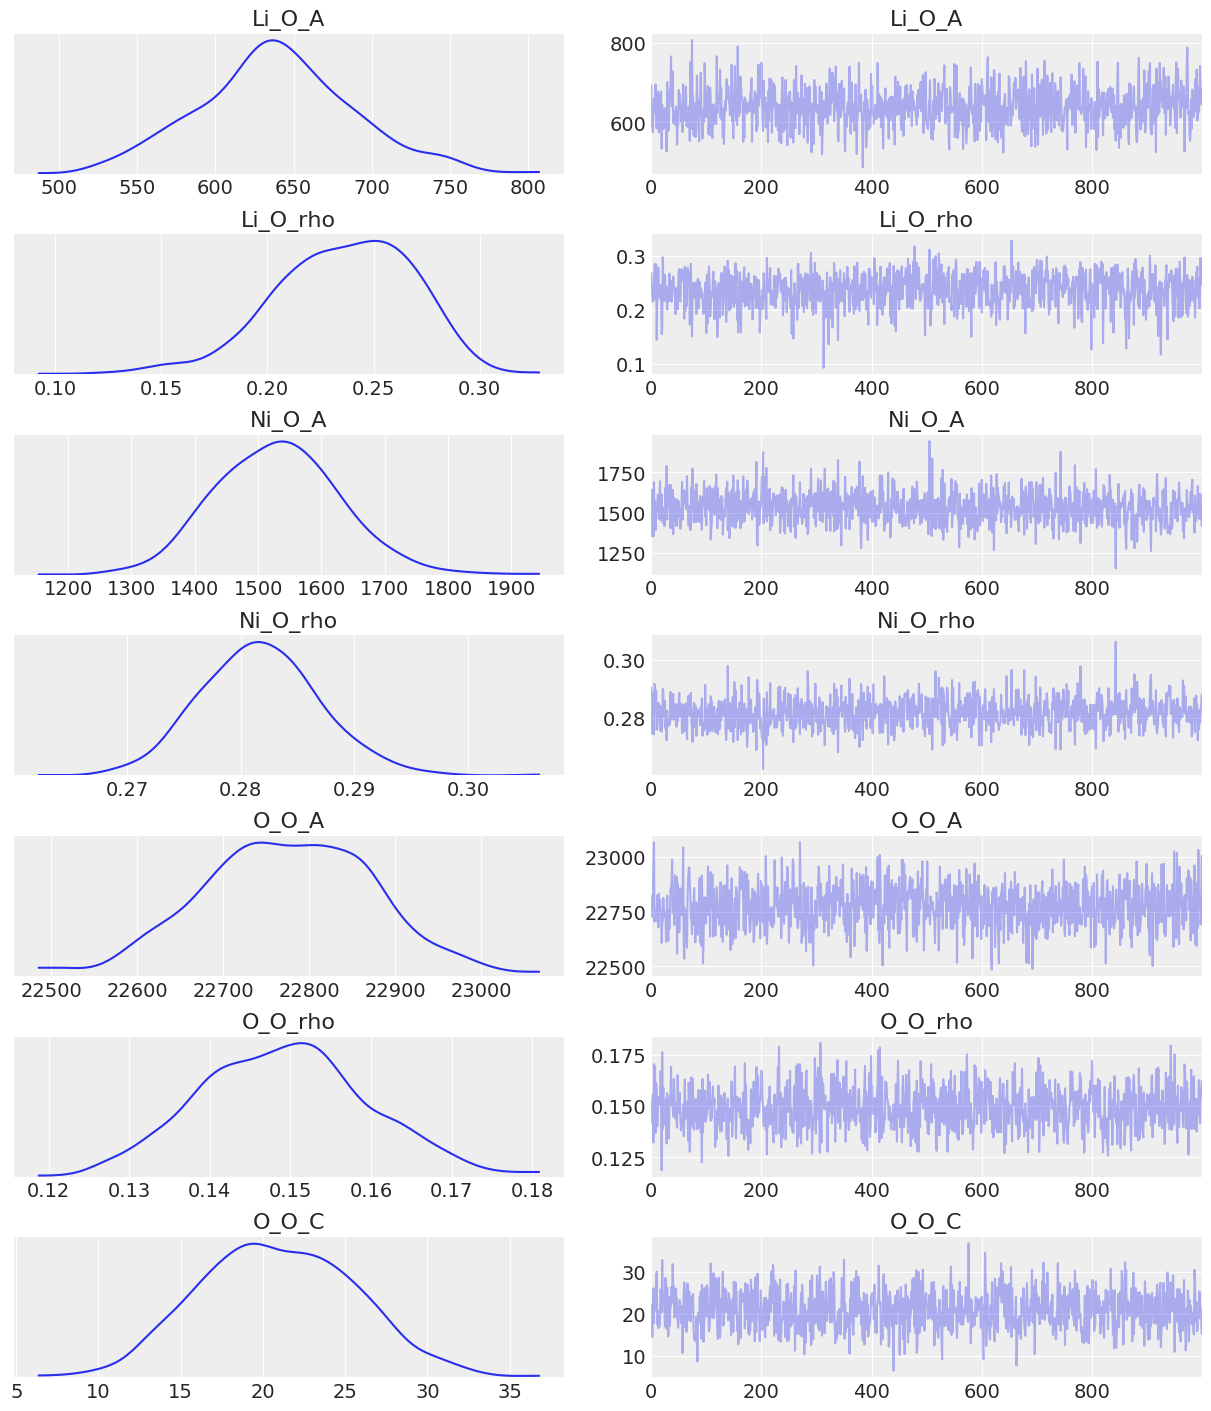

In [25]:
az.style.use('arviz-darkgrid')
az.plot_trace(trace)
plt.savefig('coreshell_LiNiO2_trace3.png',dpi=500, bbox_inches = "tight")

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


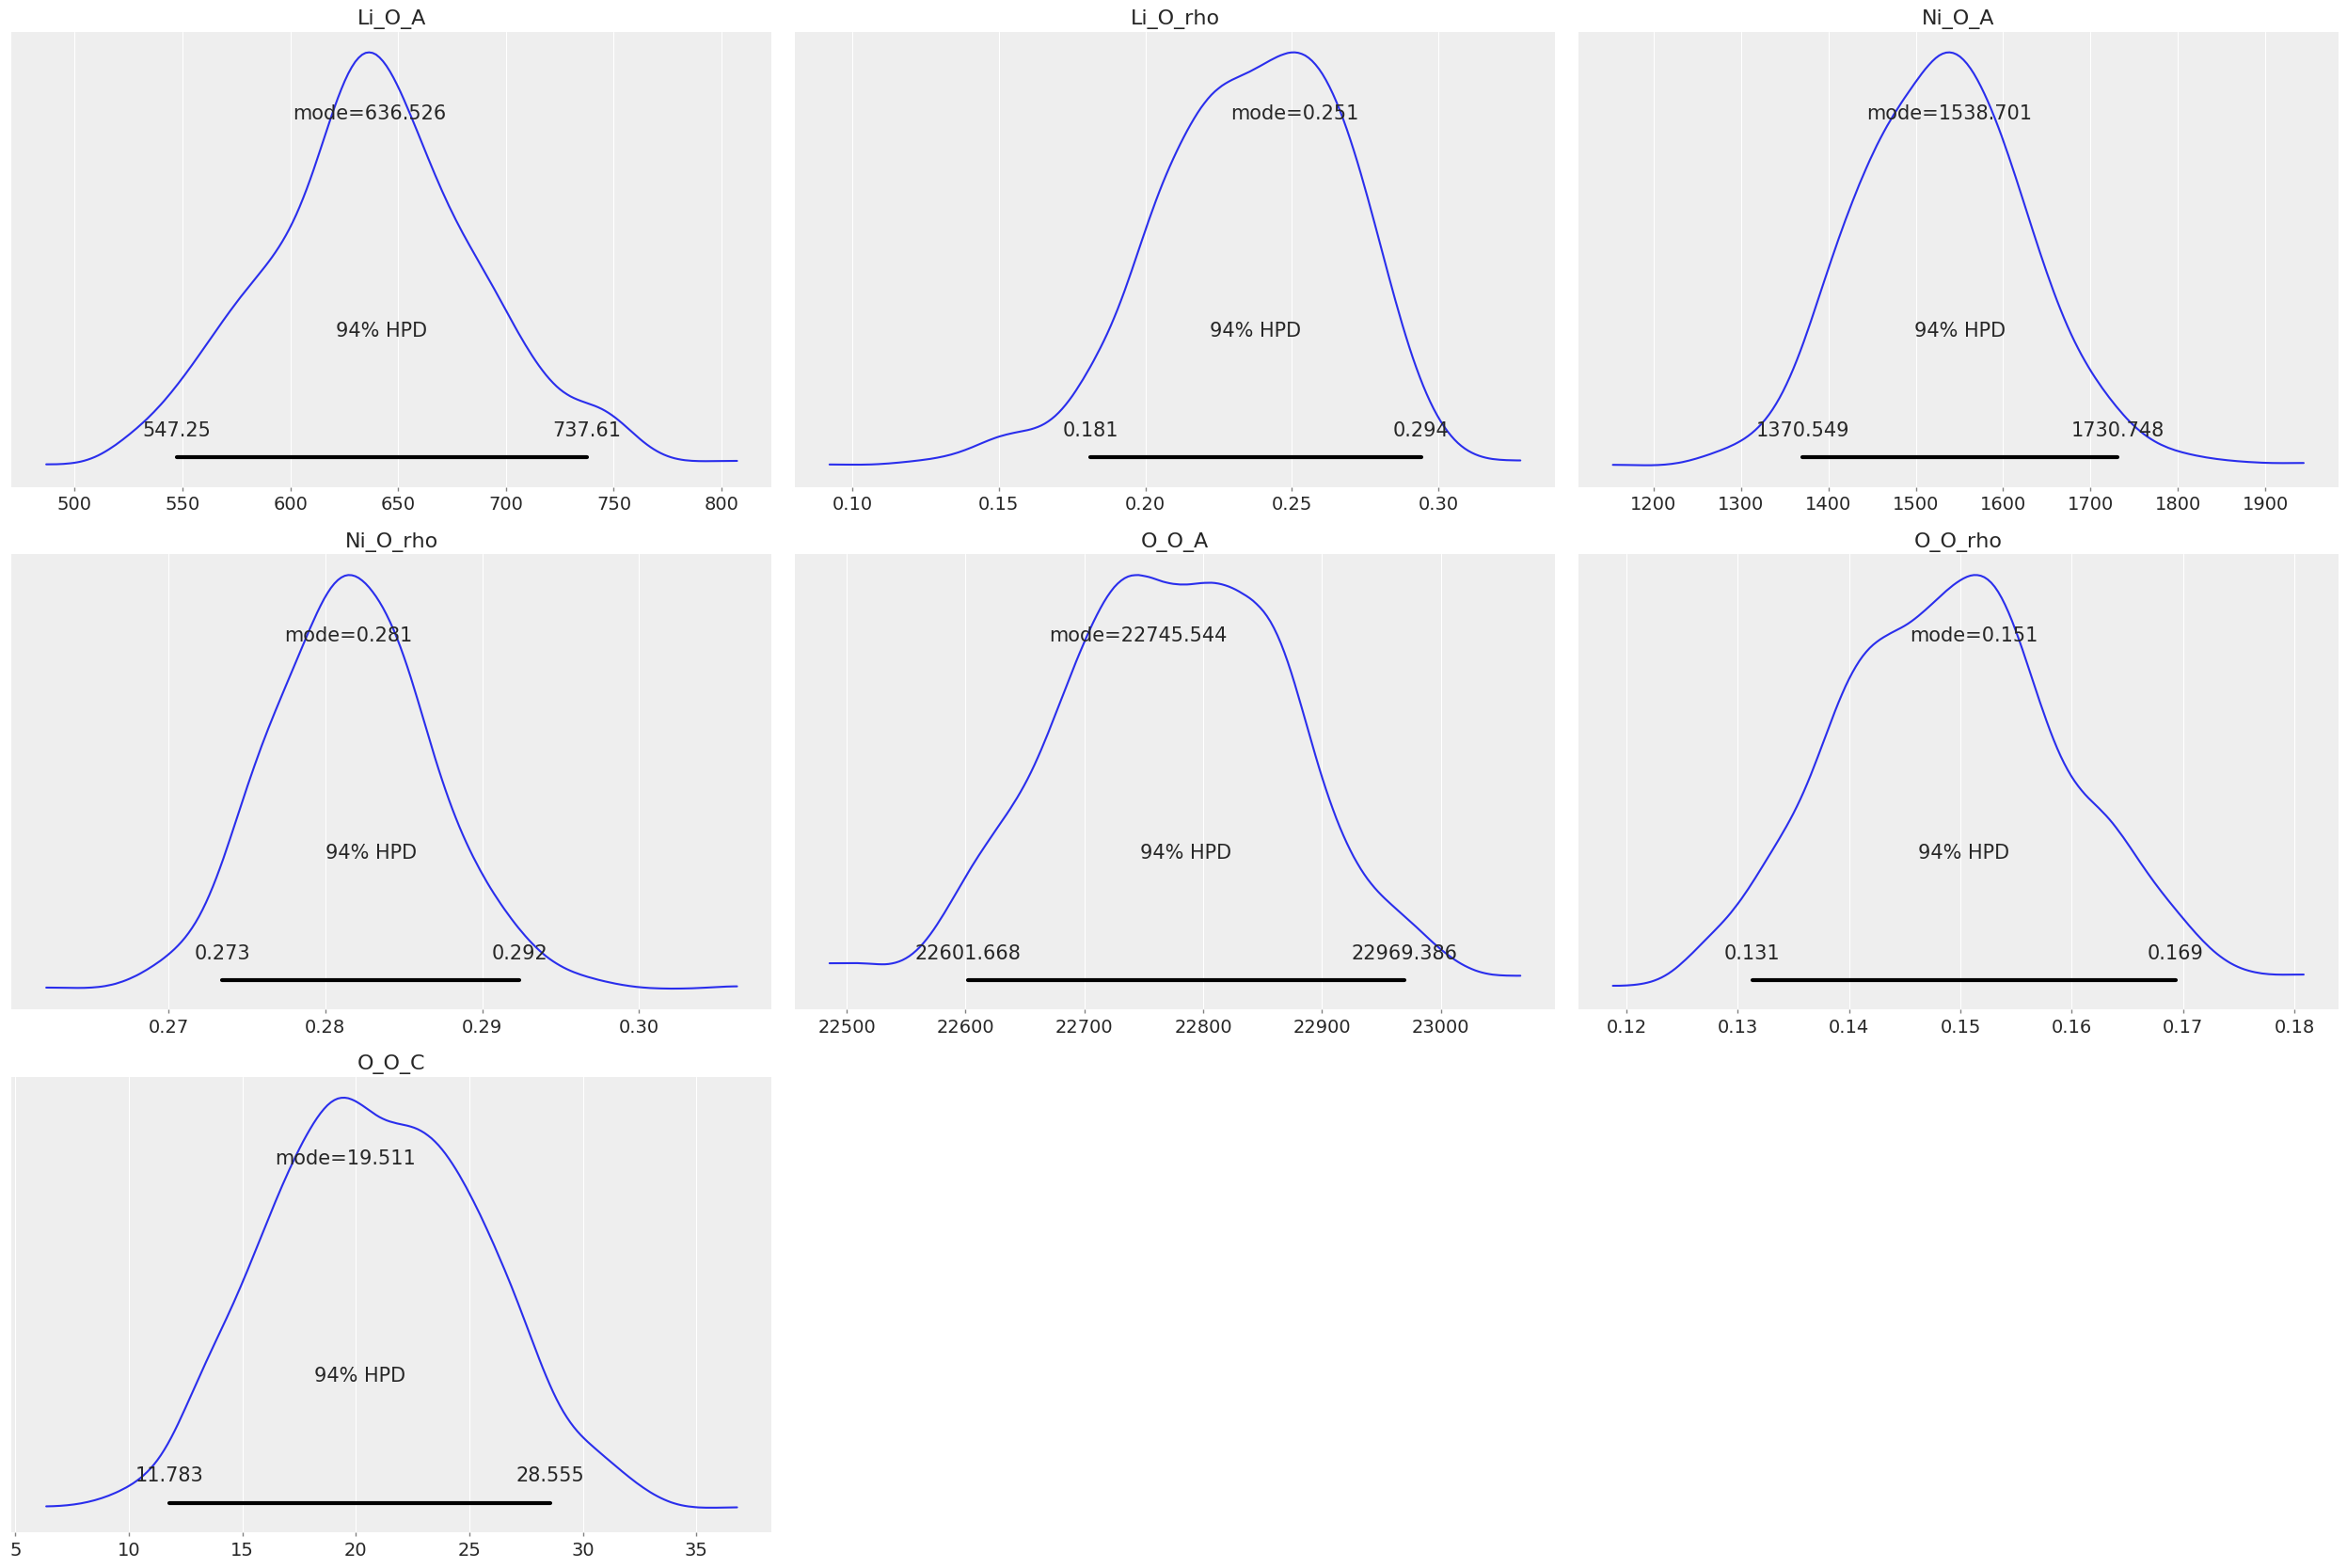

In [26]:
az.plot_posterior(trace, round_to = 3, point_estimate = 'mode')
plt.savefig('coreshell_LiNiO2_mode3.png',dpi=500, bbox_inches = "tight")

In [13]:
# fig, axes = az.plot_forest(trace,
#                            kind='ridgeplot',
#                            var_names=['Li_O_A','Ni_O_A', 'O_O_A'],
#                            combined=True,
#                            ridgeplot_overlap=10,
#                            colors='white',
#                            figsize=(9, 7))

In [14]:
# pm.summary(trace)